### Regression notebook for Wadhwani AI competition

In [1]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from pycocotools import mask as mutils
from pycocotools.coco import COCO
from mmcv import Config
from mmdet.apis import set_random_seed

import random, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from fastai.vision.all import *
import cv2
import matplotlib.patches as patches

from shapely.wkt import loads
from shapely.ops import clip_by_rect
from shapely.geometry import box
from tqdm import tqdm

/home/rajneesh/miniconda3/envs/pytorch/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
warnings.filterwarnings(action='ignore')

In [3]:
class CFG:
    seed = 46
    debug = False
    n_splits = 5
    
random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)
plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

In [4]:
DIR = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/'
IMG_PATH = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images'
submit = pd.read_csv(os.path.join(DIR,'SampleSubmission.csv'))
train = pd.read_csv(os.path.join(DIR,'Train.csv'))
test_df = pd.read_csv(os.path.join(DIR,'Test.csv'))
bbox_df = pd.read_csv(os.path.join(DIR,'images_bboxes.csv'))
bbox_df = bbox_df.groupby('image_id').agg(lambda x: list(x)).reset_index()

if CFG.debug:
    bbox_df = bbox_df.iloc[:1000,:]
    test_df = test_df.iloc[:10,:]
    #     train = train.set_index('image_id_worm').loc[bbox_df['image_id']].reset_index()
    
VERSION = "NB_EXP_DETECTION_V0_001"
MODEL_FOLDER = Path(f"///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/models/{VERSION}/")
os.makedirs(MODEL_FOLDER,exist_ok=True)
KERNEL_TYPE = f"DETECTION_BASELINE"

print(MODEL_FOLDER)
print(KERNEL_TYPE)

/mnt/c/Personal/Competitions/Zindi/Wadhwani AI/models/NB_EXP_DETECTION_V0_001
DETECTION_BASELINE


In [5]:
def getBBOX_new(df,ix):
    img = df.loc[ix,'image_id']
    geom = df.loc[ix,'geometry']
    label = df.loc[ix,'worm_type']
    img = cv2.imread(f'///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images/{img}')
    H,W,_ = img.shape
    labels = []
    
    bounds_out = []
    for i,g in enumerate(geom):
        bounding_box = loads(str(g))
        image_frame = box(0, 0, W, H)
        valid_box = clip_by_rect(bounding_box, *image_frame.bounds)
        bounds = valid_box.bounds
        
        if len(bounds)!= 4:
            continue
        bounds_out.append(bounds)
        labels.append(label[i])
        
    return bounds_out, H,W,labels

In [6]:
def getBBOX_test(df,ix):
    img = df.loc[ix,'image_id_worm']
    img = cv2.imread(f'///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images/{img}')
    H,W,_ = img.shape        
    return H,W

In [7]:
bbox_copy = bbox_df.copy()
bbox_copy = bbox_copy[~pd.isnull(bbox_copy['geometry'].apply(lambda x: x[0]))].reset_index(drop=True)
bbox_copy = bbox_copy[~pd.isnull(bbox_copy['worm_type'].apply(lambda x: x[0]))].reset_index(drop=True)
print(bbox_copy.shape)

# new_bbox = []
# Ht = []
# Wd = []
# ids = []
# labels = []

# for index in tqdm(np.arange(len(bbox_copy)),total=len(bbox_copy)):
#     try:
#         id = bbox_copy.loc[index,'image_id']
#         bounds,H,W,label = getBBOX_new(bbox_copy,index)
#     except:
#         continue    

#     ids.append(id)
#     new_bbox.append(bounds)
#     Ht.append(int(H))
#     Wd.append(int(W))
#     labels.append(label)

(6479, 3)


In [8]:
# Ht_test = []
# Wd_test = []
# ids_test = []
# labels_test = []
# new_bbox_test = []
# for index in tqdm(np.arange(len(test_df)),total=len(test_df)):
#     try:
#         id = test_df.loc[index,'image_id_worm']
#         H,W = getBBOX_test(test_df,index)
#     except:
#         continue
        
#     ids_test.append(id)
#     new_bbox_test.append([])
#     Ht_test.append(int(H))
#     Wd_test.append(int(W))
#     labels_test.append([])

In [9]:
# new_df = pd.concat([pd.Series(ids),pd.Series(new_bbox),pd.Series(Ht),pd.Series(Wd),pd.Series(labels)],1)
# new_df.rename(columns={0:'image_id',1:'bbox',2:'Height',3:'Width',4:'label'},inplace=True)
# new_df['N'] = new_df['bbox'].apply(lambda x: len(x))
# new_df.head(1)

# new_df_test = pd.concat([pd.Series(ids_test),pd.Series(new_bbox_test),pd.Series(Ht_test),pd.Series(Wd_test),pd.Series(labels_test)],1)
# new_df_test.rename(columns={0:'image_id',1:'bbox',2:'Height',3:'Width',4:'label'},inplace=True)
# new_df_test['N'] = new_df_test['bbox'].apply(lambda x: len(x))
# new_df_test.head(1)

In [10]:
# for image in new_df['image_id']:
#     np.savetxt(f'{DIR}/ann_files/{image}.txt',new_df[new_df['image_id']==image].values, fmt=['%s','%s','%d','%d','%s','%d'],delimiter='\n')
    
# for image in new_df_test['image_id']:
#     np.savetxt(f'{DIR}/ann_files/{image}.txt',new_df_test[new_df_test['image_id']==image].values, fmt=['%s','%s','%d','%d','%s','%d'],delimiter='\n')

In [68]:
def coco2yolo(bboxes, image_height=720, image_width=1280):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y2]
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    bboxes  = yolo2coco(bboxes, image_height, image_width)
    return bboxes

In [91]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module(force=True)
class WadhwaniDetectionDataset(CustomDataset):

    CLASSES = ('abw', 'pbw')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{DIR}/images/{image_id}'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}', width=width, height=height)
    
            # load annotations
            l = mmcv.list_from_file(f'{DIR}/ann_files/{image_id}.txt')            
            bbox_names = eval([line.strip().split('\n') for line in l][4][0])
            bboxes = [line.strip().split('\n') for line in l][1][0]
            bboxes = eval(bboxes)
            bboxes = [[float(k) for k in x] for x in bboxes]
            
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):                 
                if bbox_name in cat2label:
                    x1, y1, x2, y2 = bbox
                    bbox = [x1,y1,x2-x1,y2-y1]
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Get kfolds

In [92]:
def make_train_dataset():
    train_new_pbw = pd.DataFrame()
    train_new_pbw['image_id_worm']= train['image_id_worm'].unique()
    train_new_pbw = pd.merge(train_new_pbw,train[train['worm_type']=='pbw'].reset_index(drop=True),on='image_id_worm',how='left')
    train_new_pbw['worm_type'] = 'pbw'
    train_new_pbw.fillna(0,inplace=True)
    
    train_new_abw = pd.DataFrame()
    train_new_abw['image_id_worm']= train['image_id_worm'].unique()
    train_new_abw = pd.merge(train_new_abw,train[train['worm_type']=='abw'].reset_index(drop=True),on='image_id_worm',how='left')
    train_new_abw['worm_type'] = 'abw'
    train_new_abw.fillna(0,inplace=True)
    
    train_out = pd.concat([train_new_pbw,train_new_abw],0).reset_index(drop=True)
    
    assert len(train_out) == train['image_id_worm'].nunique()*2
    train_out = pd.pivot(train_out,'image_id_worm','worm_type','number_of_worms').reset_index()
    train_out[['abw','pbw']] = train_out[['abw','pbw']].astype(int)
    
    train_out['abw_cls'] = (train_out['abw']>0).astype(int)
    train_out['pbw_cls'] = (train_out['pbw']>0).astype(int)
    
    return train_out

train_new = make_train_dataset()

In [86]:
# mskf = MultilabelStratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=42)
# fold_ids = []
# train_new['fold'] = 0

# for train_index, test_index in mskf.split(train_new, train_new[['abw','pbw']]):
#     fold_ids.append(test_index)
    
# for fld in range(CFG.n_splits):
#     valIx = fold_ids[fld]
#     train_new.loc[valIx,'fold']=fld 

In [15]:
# new_df = pd.merge(new_df,train_new[['image_id_worm','fold']],left_on='image_id',right_on='image_id_worm',how='left').drop('image_id_worm',1)

In [16]:
# bbox_train = new_df[new_df['fold']!= 0].reset_index(drop=True)
# bbox_val = new_df[new_df['fold']== 0].reset_index(drop=True)

In [17]:
# np.savetxt(f'{DIR}/image_list_files/image_list_train.txt', bbox_train.image_id.values, fmt='%s')
# np.savetxt(f'{DIR}/image_list_files/image_list_val.txt', bbox_val.image_id.values, fmt='%s')
# np.savetxt(f'{DIR}/image_list_files/image_list_test.txt', new_df_test.image_id.values, fmt='%s')

In [93]:
from mmcv import Config

cfg = Config.fromfile('///home/rajneesh/mmdetection/configs/faster_rcnn/faster_rcnn_x101_32x4d_fpn_1x_coco.py')

In [19]:
# cfg.model.bbox_head

In [94]:
cfg.keys()

dict_keys(['model', 'dataset_type', 'data_root', 'img_norm_cfg', 'train_pipeline', 'test_pipeline', 'data', 'evaluation', 'optimizer', 'optimizer_config', 'lr_config', 'runner', 'checkpoint_config', 'log_config', 'custom_hooks', 'dist_params', 'log_level', 'load_from', 'resume_from', 'workflow', 'opencv_num_threads', 'mp_start_method', 'auto_scale_lr'])

In [95]:
# Modify dataset type and path

cfg.dataset_type = 'WadhwaniDetectionDataset'
cfg.data_root = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/'

cfg.data.test.type = 'WadhwaniDetectionDataset'
cfg.data.test.data_root = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/'
cfg.data.test.ann_file = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/image_list_files/image_list_test.txt'
cfg.data.test.img_prefix = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images/'

cfg.data.train.type = 'WadhwaniDetectionDataset'
cfg.data.train.data_root = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/'
cfg.data.train.ann_file = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/image_list_files/image_list_train.txt'
cfg.data.train.img_prefix = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images/'

cfg.data.val.type = 'WadhwaniDetectionDataset'
cfg.data.val.data_root = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/'
cfg.data.val.ann_file = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/image_list_files/image_list_val.txt'
cfg.data.val.img_prefix = '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/data/images/'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 2
# cfg.model.bbox_head.num_classes = 2

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
# cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = f'{MODEL_FOLDER}'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.optimizer.lr = 0.0001
# cfg.lr_config.warmup = None
# cfg.log_config.interval = 10

# cfg.runner = {'type': 'EpochBasedRunner', 'max_epochs': 15}
cfg.data.samples_per_gpu = 8 
cfg.workers_per_gpu = 8
# cfg.lr_config.step = [11,14]

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 5
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device='cuda'

In [96]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

Invalid SOS parameters for sequential JPEG


In [97]:
input = datasets.__getitem__(0)
input.data_infos[0]

{'filename': 'id_0005ef295aafe6acc63587db.jpg',
 'width': 3120,
 'height': 4160,
 'ann': {'bboxes': array([[1587.45, 2631.2 ,   97.77,  348.41],
         [1296.7 , 1850.31,  154.34,  213.59],
         [1547.51, 2321.35,  106.04,  187.29],
         [1363.07, 1169.51,  215.96,  118.62],
         [1639.78, 2292.43,  130.83,  224.47],
         [ 709.83, 1055.61,  190.71,  125.82],
         [ 654.54, 2289.89,  248.04,  115.75],
         [ 701.36,  940.51,  208.76,  148.96]], dtype=float32),
  'labels': array([1, 1, 1, 1, 1, 1, 1, 1]),
  'bboxes_ignore': array([], shape=(0, 4), dtype=float32),
  'labels_ignore': array([], dtype=int64)}}

In [98]:
input.get_ann_info(0)

{'bboxes': array([[1587.45, 2631.2 ,   97.77,  348.41],
        [1296.7 , 1850.31,  154.34,  213.59],
        [1547.51, 2321.35,  106.04,  187.29],
        [1363.07, 1169.51,  215.96,  118.62],
        [1639.78, 2292.43,  130.83,  224.47],
        [ 709.83, 1055.61,  190.71,  125.82],
        [ 654.54, 2289.89,  248.04,  115.75],
        [ 701.36,  940.51,  208.76,  148.96]], dtype=float32),
 'labels': array([1, 1, 1, 1, 1, 1, 1, 1]),
 'bboxes_ignore': array([], shape=(0, 4), dtype=float32),
 'labels_ignore': array([], dtype=int64)}

In [99]:
def plot_image_and_bboxes(img, bboxes, labels):
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(img)
    c = 0
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor="none")
        ax.annotate(str(labels[c])+ " : ", (bbox[0], bbox[1]-6), color='red', weight='bold', fontsize=12, ha='center', va='center')
        ax.add_patch(rect)
        c+=1    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


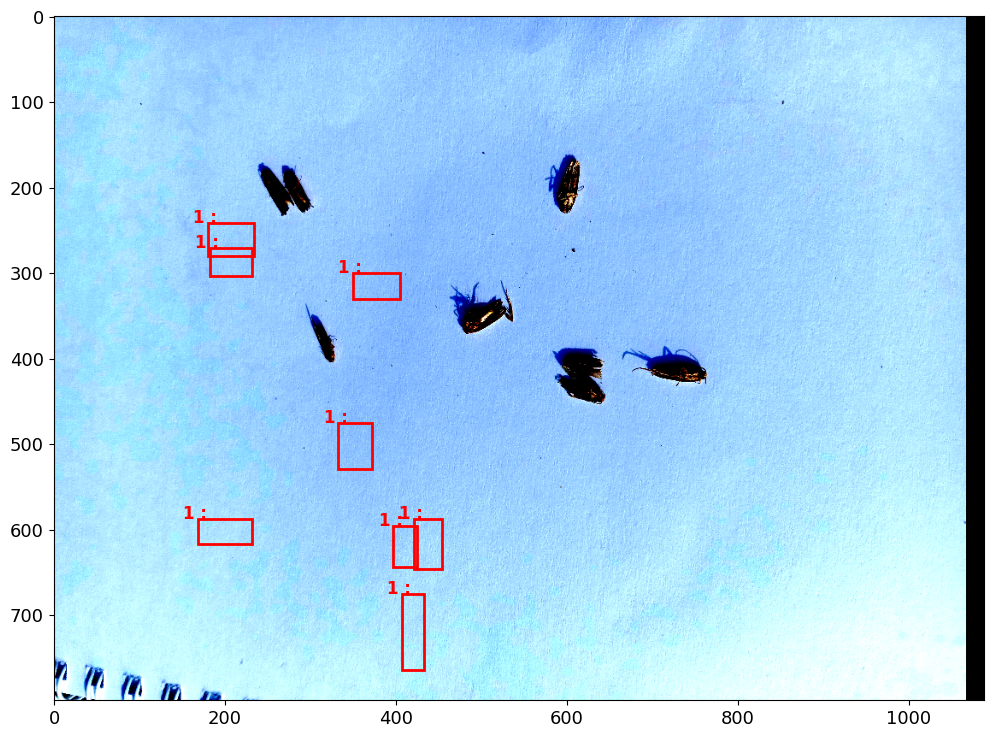

In [100]:
plot_image_and_bboxes(input.prepare_train_img(0)['img'].data.numpy().transpose(2,1,0),
                      input.prepare_train_img(0)['gt_bboxes'].data.numpy(),
                     input.prepare_train_img(0)['gt_labels'].data.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


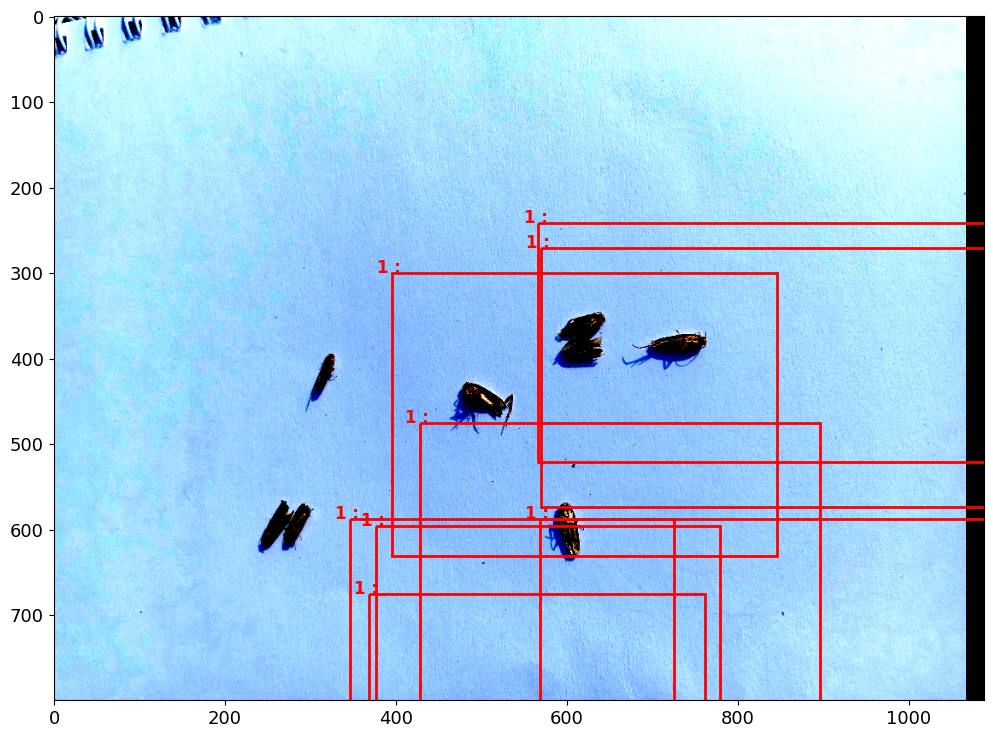

In [67]:
plot_image_and_bboxes(input.prepare_train_img(0)['img'].data.numpy().transpose(2,1,0),
                      input.prepare_train_img(0)['gt_bboxes'].data.numpy(),
                     input.prepare_train_img(0)['gt_labels'].data.numpy())

In [33]:
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [34]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-11-11 16:23:00,929 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-11-11 16:24:56,230 - mmdet - INFO - Start running, host: rajneesh@Rajneesh, work_dir: /mnt/c/Personal/Competitions/Zindi/Wadhwani AI/models/NB_EXP_DETECTION_V0_001
2022-11-11 16:24:56,231 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook        

OutOfMemoryError: CUDA out of memory. Tried to allocate 170.00 MiB (GPU 0; 23.99 GiB total capacity; 21.88 GiB already allocated; 0 bytes free; 22.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# !ls '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/models/NB_EXP_DETECTION_V0_001/latest.pth'

In [ ]:
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

checkpoint = load_checkpoint(model, '///mnt/c/Personal/Competitions/Zindi/Wadhwani AI/models/NB_EXP_DETECTION_V0_001/latest.pth'
                             , map_location='cpu')

In [ ]:
from mmdet.apis.test import single_gpu_test
from mmdet.datasets import build_dataloader
# build the dataloader
dataset_test = build_dataset(cfg.data.test)

In [ ]:
data_loader = build_dataloader(
    dataset_test,
    samples_per_gpu=1,
    workers_per_gpu=1,
    dist=False,
    shuffle=False)

In [ ]:
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader, show=False)

In [ ]:
len(outputs),len(test_df)

In [ ]:
# outputs

In [ ]:
ABW = []
PBW = []
for imgs in tqdm(range(len(outputs))):
    l = outputs[imgs]
    N_ABW = len(l[0])
    N_PBW = len(l[1])
    ABW.append(N_ABW)
    PBW.append(N_PBW)    

In [ ]:
test_df['abw'] = ABW
test_df['pbw'] = PBW
test_df.head()

In [ ]:
test_df_melt = test_df.melt('image_id_worm',['abw','pbw'],value_name='number_of_worms')
test_df_melt['image_id_worm'] = test_df_melt['image_id_worm'].apply(lambda x: x.split('.')[0])
test_df_melt['image_id_worm'] = test_df_melt['image_id_worm']+"_"+test_df_melt['variable']
test_df_melt.drop(['variable'],1,inplace=True)
test_df_melt.tail()

In [ ]:
submit = pd.merge(submit.drop('number_of_worms',1),test_df_melt,on='image_id_worm',how='left')
submit.head()

In [ ]:
submit.to_csv(f'{MODEL_FOLDER}/detection_preds.csv',index=False)

### Fin 